In [ ]:
import torchvision
import torch
import numpy as np
from collections import defaultdict
import torch.nn as nn
from ast import Continue

import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/11-785 Project/MNIST_CSV.zip' MNIST_CSV.zip

In [ ]:
!unzip data/MNIST_CSV.zip

## Config

In [ ]:
n_epochs = 20
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
HYPER_GRAYSCALE = True

In [ ]:
config = {
    'n_epochs': n_epochs,
    'batch_size_train': batch_size_train,
    'batch_size_test': batch_size_test,
    'learning_rate': learning_rate,
    'momentum': momentum,
    'log_interval': log_interval,
    'random_seed': random_seed,
    'HYPER_GRAYSCALE': HYPER_GRAYSCALE
}

## Data Preprocessing

In [ ]:
train_set = pd.read_csv("mnist_train.csv")
test_images = pd.read_csv("mnist_test.csv")

train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:],
                                                                     train_set.iloc[:, 0],
                                                                     test_size=0.3)

train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

train_images = train_images.to_numpy(dtype='float32')
train_labels = train_labels.to_numpy(dtype='float32')

val_images = val_images.to_numpy()
val_labels = val_labels.to_numpy()

test_images = test_images.to_numpy()

## Jigsaw Datasets

### Value Network Datasets

In [ ]:
class ValueDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = True

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_shuffled_image(self, index,  shuffles):
        img = self.__get_image(index).reshape(28, 28)[:27,:27]
        shuffle_image = np.zeros((27, 27), dtype='float32')

        shuff_list = np.random.choice(9, 2*shuffles, replace=False)
        for i in range(shuffles):
          q, w = shuff_list[i*2], shuff_list[i*2+1]
          a, b = q//3, q % 3
          i, j = w//3, w % 3
          img[i*9:i*9+9, j*9:j*9+9], img[a*9:a*9+9, b*9:b*9+9] = img[a*9:a*9+9, b*9:b*9+9] , img[i*9:i*9+9, j*9:j*9+9]

        return img

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        shuffles = np.random.randint(0,5)

        # order = self.__retrieve_permutations()
        item = self.__get_shuffled_image(index, shuffles)

        data_index = torch.from_numpy(np.array(order))
        # data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]
        # item = torch.stack(data, 0)
        if self.GRAYSCALE:
          item = np.repeat(item[ np.newaxis, :, :], 3, axis=0)

        return item, torch.tensor(1 - 0.25*shuffles, dtype = torch.float32), int(self.labels[index])

    def __len__(self):
        return self.N

### Test Datasets

In [ ]:
class ValueDatasetTest(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = True

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_shuffled_image(self, index,  shuffles):
        img = self.__get_image(index).reshape(28, 28)[:27,:27]
        shuffle_image = np.zeros((27, 27), dtype='float32')

        shuff_list = np.random.choice(9, 2*shuffles, replace=False)
        for i in range(shuffles):
          q, w = shuff_list[i*2], shuff_list[i*2+1]
          a, b = q//3, q % 3
          i, j = w//3, w % 3
          img[a*9:a*9+9, b*9:b*9+9] = img[i*9:i*9+9, j*9:j*9+9]

        return img

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        shuffles = np.random.randint(0,5)

        # order = self.__retrieve_permutations()
        item = self.__get_shuffled_image(index, shuffles)

        data_index = torch.from_numpy(np.array(order))
        # data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]
        # item = torch.stack(data, 0)
        if self.GRAYSCALE:
          item = np.repeat(item[ np.newaxis, :, :], 3, axis=0)

        return item

    def __len__(self):
        return self.N

# Initialize the Datasets

In [ ]:
train_data_value = ValueDataset(train_images, train_labels)
val_data_value = ValueDataset(val_images, val_labels)
test_data_value = ValueDatasetTest(test_images)


train_loader_value = torch.utils.data.DataLoader(
        dataset     = train_data_value,
        num_workers = 2,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = True,
)

val_loader_value = torch.utils.data.DataLoader(
        dataset     = val_data_value,
        num_workers = 2,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader_value = torch.utils.data.DataLoader(
        dataset     = test_data_value,
        num_workers = 1,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = False,
    )

Train dataset samples = 41999, batches = 41999
Val dataset samples = 18000, batches = 18000
Test dataset samples = 9999, batches = 9999


torch.Size([32, 3, 27, 27])
tensor(0.7500)


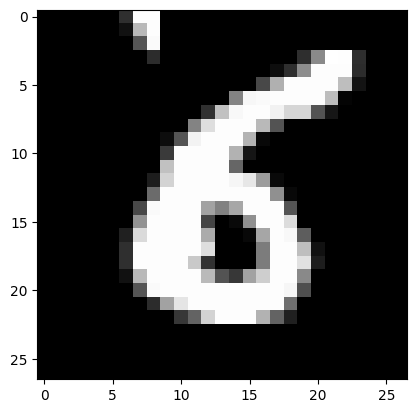

In [ ]:
for img, shuffles, label in train_loader_value:
  print(img.shape)
  plt.imshow(img[0,0,:,:], cmap='gray')
  print(shuffles[0])

  break

## Value Network

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear = nn.Linear(1000, 16)
        self.linear2 = nn.Linear(16, 1)
        self.softmax = nn.Softmax()
        self.flat = nn.Flatten()



    def forward(self, x):

        x = self.resnet(x)
        x = self.linear(x)
        x = self.linear2(x)
        x = self.softmax(x)
        x = self.flat(x)
        x = torch.squeeze(x)

        return x

# Model Training

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)


        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

### **Train Value Network**

In [ ]:
def train_value(model, dataloader, optimizer, criterion):

    model.train()
    optimizer.zero_grad()
    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    tot_error = 0
    total_loss  = 0
    error_percs = []
    losses = []
    for i, (images, labels, num_label) in enumerate(dataloader):

        # optimizer.zero_grad() # Zero gradients
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # labels = torch.zeros((32,1), dtype=torch.float32)
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        tot_error   += float(sum((outputs - labels)**2))
        total_loss  += float(loss.item())
        error_perc  = 100 * tot_error / (batch_size_train*(i + 1))

        batch_bar.set_postfix(
            error_perc  = "{:.04f}%".format(100 * tot_error / (batch_size_train*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            tot_error   = tot_error
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        if i % 10 == 0:
          losses.append(loss)
          error_percs.append(error_perc)
        
        # uncomment for mixed precision
        # scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # scaler.step(optimizer) # This is a replacement for optimizer.step()
        # scaler.update()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    error_perc         = 100 * tot_error / (batch_size_train* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return error_perc, total_loss, losses, error_percs

In [ ]:
criterion_value = torch.nn.MSELoss()
Model_val = ValueNetwork().to(DEVICE)
# summary(Model_val, (3, 27, 27))
optimizer_val = torch.optim.SGD(Model_val.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)


In [ ]:
errors = []
loss_totals = []
a = []
b= []

In [ ]:
for i in range(config['n_epochs']):
  err, total_loss, losses, error_percs = train_value(Model_val, train_loader_value, optimizer_val, criterion_value)
  errors.append(err)
  loss_totals.append(total_loss)
  a.append(losses)
  b += error_percs
  torch.save({'model_state_dict':Model_val.state_dict(),
              'optimizer_state_dict':optimizer_val.state_dict()}, './model_value.pth')

In [ ]:
torch.save({'model_state_dict':Model_val.state_dict(),
            'optimizer_state_dict':optimizer_val.state_dict()}, './model_value.pth')

In [ ]:
model = ValueNetwork()
model.load_state_dict('./model_value.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: ignored

Text(0, 0.5, 'MSE Loss (%)')

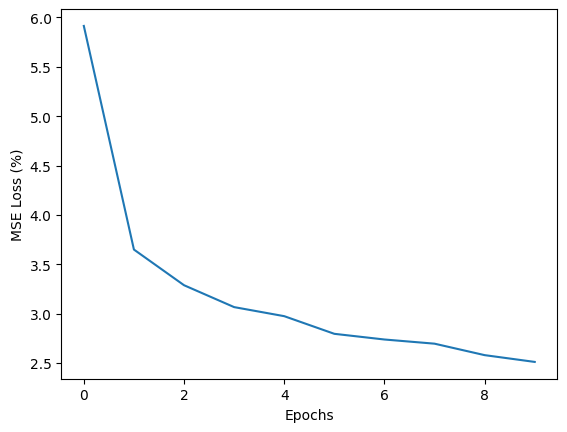

In [ ]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (%)')

Text(0, 0.5, 'MSE Loss')

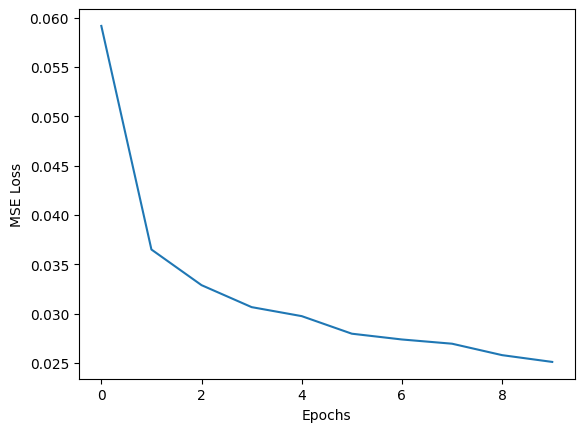

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_totals)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

Text(0, 0.5, 'MSE Loss')

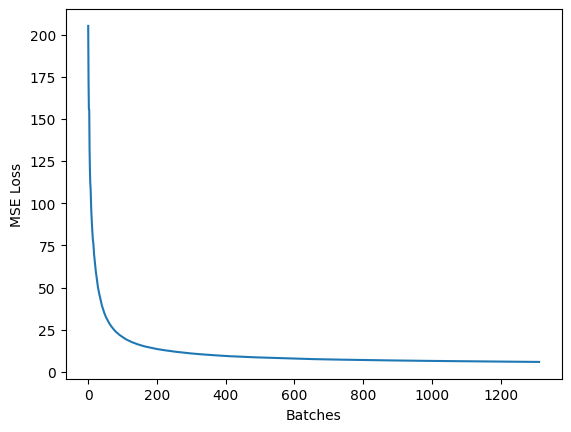

In [ ]:
import matplotlib.pyplot as plt
plt.plot(b[0])
plt.xlabel('Batches')
plt.ylabel('MSE Loss')